# TP Final: Aprendizaje de Máquina I

Para este TP obtuve el set de datos disponible en Kaggle (https://www.kaggle.com/zynicide/wine-reviews) relativo a una base de datos sobre opiniones realizadas por diversos sommeliers acerca de distintos vinos producidos alrededor del mundo. La idea es trabajar sobre el mismo aplicando los conceptos aprendidos en la materia.

## Limpieza de datos
Como primer medida debemos visualizar y limpiar los datos si fuese necesario. Lo primero a analizar es esas entradas que tengan valores vacíos en alguno de sus campos. Además deberemos analizar si hay campos completos de los que se pueda prescindir (ya sea porque les faltan demasiados valores o porque no presentan información relevante)

In [24]:
# Cargamos módulos necesarios
#============================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor

In [25]:
# Una vista de lo que contiene la tabla de datos
#===============================================
ds = pd.read_csv('winemag-data-130k-v2.csv')
ds.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [26]:
ds.describe()
# De dónde sale el Unnamed:0 ???

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


Valores 'Null' por columna: 
 
 Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64


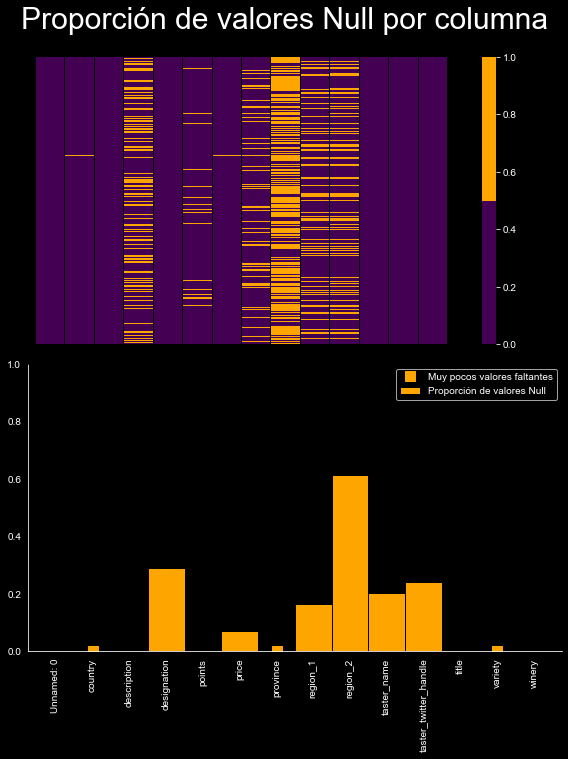

In [28]:
# La siguiente limpieza de datos está basada en el siguiente código: https://www.kaggle.com/milankalkenings/wine-reviews-data-cleaning
#------------------------------------------------------------------------------------------------------
def nullscan(ds_check, dcb):
    '''
    ds_check: el dataset que queremos verificar
    
    Grafica la proporción de valores null por columna en el DS usando el mapa caliente de seaborn y barplot
    '''    
    # Verificamos los nans
    ds_nulls = ds_check.isnull()
    # Cantidad de nulls por columna
    nulls_per_col = ds_nulls.sum(axis=0)
    print("Valores 'Null' por columna: \n \n", nulls_per_col)
    # the rate makes it way more interpretable:
    nulls_per_col /= len(ds_check.index)

    with plt.style.context('dark_background'):
        
        # Armamos la figura
        #------------------
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 10))
    
        # colormap customizado
        vir = matplotlib.cm.get_cmap('viridis')
        colormap = matplotlib.colors.ListedColormap([vir(0), 'orange'])
        
        # Acá armamos el mapa de seaborn
        #-------------------------------
        sns.heatmap(ds_check.isnull(), cmap=colormap, cbar=dcb, yticklabels=False, ax=ax1)
        
        # Acá armamos el plot de barras
        #------------------------------
        nulls_per_col.plot(kind='bar', color='orange', x=nulls_per_col.values, y=nulls_per_col.index, ax=ax2, 
                       width=1, linewidth=1, edgecolor='black', align='edge', label='Proporción de valores Null')
        
        ax2.set_ylim((0,1))
        
        # centered labels
        labels=ds_check.columns
        ticks = np.arange(0.5, len(labels))
        ax2.xaxis.set(ticks=ticks, ticklabels=labels)
    
        # Ocultar "spines".
        ax2.spines['top'].set_color('black')
        ax2.spines['right'].set_color('black')
        
        # Viendo cómo visualizar muy poca cantidad de nulls por columna
        na_ticks = ticks[(nulls_per_col > 0) & (nulls_per_col < 0.05)]
        if (len(na_ticks) > 0):
            ax2.plot(na_ticks, [0,]*len(na_ticks), 's', c='orange', markersize=10, 
                     label='Muy pocos valores faltantes')
    
        fig.suptitle('Proporción de valores Null por columna', fontsize=30, y=1.05)
        ax2.legend()
        fig.tight_layout() 
        plt.savefig('nullscan.png')
        plt.show()

# Verifico los null en el dataset
#================================
nullscan(ds,True)

### Manejo de valores vacíos (null)

Luego de eliminar las filas (entradas) y/o columnas de datos vacíos que se pudieran debemos ver qué hacemos con aquellas entradas que no se pudieron eliminar y que queremos preservar (y utilizar en el análisis) \n

Formas habituales de manejar valores nulos:

- Eliminar filas que contengan una cantidad específica de valores nulos. Utilizar este método únicamente si el número de valores perdidos dentro de la fila respectiva es muy alto y dichos valores son relevantes.
- Eliminar las columnas que contengan una cantidad específica de valores nulos si la columna no es demasiado relevante y la cantidad de valores perdidos es muy grande.
- Reemplazar los valores faltantes con el promedio de la columna. El valor más común de una característica categórica y la mediana o la media de una característica numérica se pueden interpretar como el promedio de la columna respectiva.
- Reemplazar el valor faltante con un valor predicho. Se podría usar KNN y reemplazar el valor faltante con el valor más frecuente dentro de los vecinos más cercanos.
- Reemplazar los valores faltantes con ceros o 'Desconocido' y tratarlos como cualquier otro valor si es posible
- Además de estos métodos estándar, una mayor comprensión del conjunto de datos y su contexto puede revelar otros métodos adecuados.

Filas que contienen nombre pero no cuenta de twitter: 4969 
Filas que contienen cuenta de twitter pero no nombre: 0

Cuentas de Twitter por Sommelier:

taster_name
Alexander Peartree    0
Anna Lee C. Iijima    0
Anne Krebiehl MW      1
Carrie Dykes          0
Christina Pickard     1
Fiona Adams           1
Jeff Jenssen          1
Jim Gordon            1
Joe Czerwinski        1
Kerin O’Keefe         1
Lauren Buzzeo         1
Matt Kettmann         1
Michael Schachner     1
Mike DeSimone         1
Paul Gregutt          1
Roger Voss            1
Sean P. Sullivan      1
Susan Kostrzewa       1
Virginie Boone        1
Name: taster_twitter_handle, dtype: int64


Valores 'Null' por columna: 
 
 Unnamed: 0     0
country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
dtype: int64


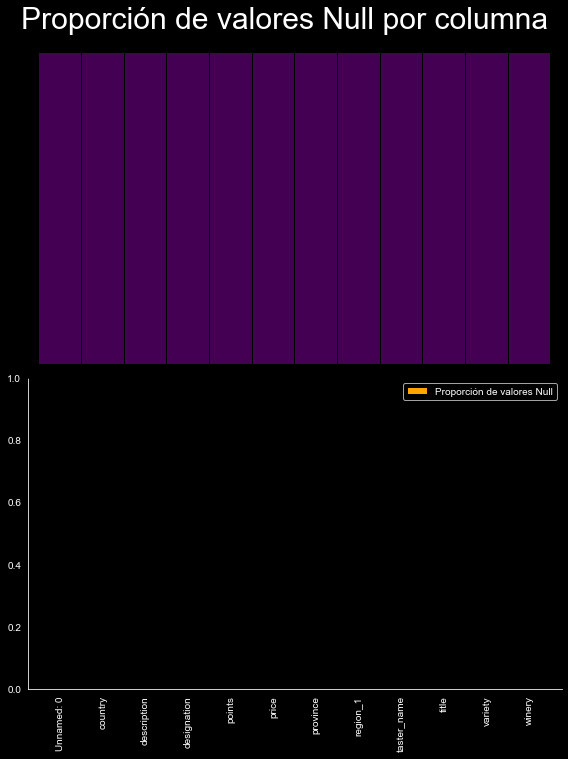

In [29]:
# Dado que las columnas 'country', 'province' y 'variety' tienen pocos valores Null
# eliminamos directamente esas filas completas para todos los campos.
#--------------------------------------------------------------------
ds = ds.dropna(subset=['country', 'province', 'variety'])

# Dado que la columna 'region_2' contiene demasiados Null la eliminamos directamente. (Sabiendo también
# que no nos agrega mucho esa columna como información relevante).
#-----------------------------------------------------------------
ds = ds.drop('region_2', axis=1)

# En el caso de los tipos de vinos 'designation' o las regiones 'region_1' que contienen datos vacíos
# es lógico indicarles un valor desconocido 'unknown' ya que son ambas variables categóricas, que no
# se les puede asignar otra etiqueta presente en dichas columnas sin corromper los datos. Por otro
# lado no tiene sentido eliminar esas filas o columnas porque el resto de los datos a los que esas
# entradas pertenecen aportan información relevante.
#---------------------------------------------------
ds[['designation', 'region_1']] = ds[['designation', 'region_1']].fillna('Unknown')

# También tenemos datos vacíos en las columnas 'tester_name' y 'tester_twitter_handle'. En estos campos
# ambos valores identifican a un mismo 'tester' o sommelier, por eso podría ser prudente realizar una
# unión entre ambos campos dando prioridad al campo 'tester_name'. Pero también podría pasar que un
# mismo sommelier tenga varias cuentas de twitter a través de las que realiza sus reviews (ya sea porque
# utiliza más de una o porque cierra una y abre otra). Para salir de dudas de cuál es la situación en
# este data set corremos el siguiente código.
# -------------------------------------------
only_name = ds.loc[ds['taster_twitter_handle'].isnull() & ds['taster_name'].notna(), 
                   ['taster_name', 'taster_twitter_handle']]
num_only_name = len(only_name.index)

only_twitter = ds.loc[ds['taster_name'].isnull() & ds['taster_twitter_handle'].notna(), 
                      ['taster_name', 'taster_twitter_handle']]
num_only_twitter = len(only_twitter.index)

print(f'Filas que contienen nombre pero no cuenta de twitter: {num_only_name} \nFilas que contienen cuenta de twitter pero no nombre: {num_only_twitter}')

# Dado el resultado anterior verificamos cuáles son los sommeliers que contienen múltiples cuentas de twitter
#------------------------------------------------------------------------------------------------------------
twitter_per_name = ds.groupby('taster_name')['taster_twitter_handle'].nunique()
print('\nCuentas de Twitter por Sommelier:\n')
print(twitter_per_name)
print('\n')

# Como se ve del resultado anterior o bien los sommeliers usan una cuenta de twitter o ninguna, por lo
# que simplemente se puede desechar la columna 'twitter_handle' y además rellenar los 'tester_name'
# vacíos con 'unknown'
#---------------------------------------------------------------------------------------------------
ds = ds.drop('taster_twitter_handle', axis=1)
ds['taster_name'] = ds['taster_name'].fillna('Unknown')

# Finalmente la única columna que queda aún con valores vacíos es la de precio 'price'. Se podría
# reemplazar todos los valores vacíos por la media de la columna...pero esto daría lugar a valores
# algo imprecisos. En cambio también se podría predecir esos valores utilizando KNN. Seguirían siendo
# 'valores inventados' pero con un criterio mucho más robusto con menor error. Para hacerlo se utilizarán
# las características 'country' y 'points' para agrupar. Por otro lado ya que se predecirán valores
# numéricos se utilizará un modelo de regresión (KNeighboursRegressor) de sklearn
#--------------------------------------------------------------------------------

# Cambiamos 'country' y 'taster_name' a variables de indexado
ds_cleanup = ds.loc[:, ['price', 'points', 'country', 'taster_name']]
encoded = pd.get_dummies(ds_cleanup[['country', 'taster_name']], prefix=['country', 'taster_name'])
ds_cleanup = pd.concat([ds_cleanup.drop(['country', 'taster_name'], axis=1), encoded], axis=1)

# Training data
ds_cleanup_known = ds_cleanup.loc[ds_cleanup['price'].notnull(), :]
X_known = ds_cleanup_known.drop('price', axis=1)
y_known = ds_cleanup_known['price']

# Prediction data
ds_cleanup_unknown = ds_cleanup.loc[ds_cleanup['price'].isnull(), :]
X_unknown = ds_cleanup_unknown.drop('price', axis=1)

# Creamos el regresor
knn_cleanup = KNeighborsRegressor(n_neighbors=10)
knn_cleanup.fit(X=X_known, y=y_known)

# Predecimos los precios y concatenamos los datos
ds_known = ds.loc[ds['price'].notnull(),:]
ds_predicted = ds.loc[ds['price'].isnull(),:]

# Para evadir SettingWithCopyWarning
ds_predicted = ds_predicted.drop('price', axis=1)
ds_predicted['price'] = knn_cleanup.predict(X_unknown)
ds = pd.concat([ds_known, ds_predicted], axis=0, ignore_index=True)

# Barajamos el dataset en las filas
#ds = ds.sample(frac=1).reset_index(drop=True)

# Finalmente mostramos cómo quedo el data set en relación a los null
#-------------------------------------------------------------------
nullscan(ds,False)

In [30]:
# Ya que los limpiamos los salvamos a disco así no tenemos que volverlo a hacer!!
#================================================================================
ds.to_csv('clean_data.csv')

In [40]:
# --> POSIBLE PUNTO DE ARRANQUE

# Si arrancamos desde acá (y no desde antes de limpiar los datos) entonces levantamos el archivo
#-----------------------------------------------------------------------------------------------
ds = pd.read_csv('clean_data.csv')

## (mini)-ingeniería de características
Más allá de las características (columnas) propias del dataset es posible extraer algunas características extra a partir de las mismas. Por ejemplo en el campo 'title' se ve que figuran los años de cada vino, dato que sería muy bueno tenerlo aislado. Veamos cómo recuperarlo!.
(basado en https://www.kaggle.com/bowtiewarcry/wine-reviews-feature-engineering)

In [31]:
# Recuperamos la información de año del campo título
#===================================================

# Importamos el módulo para manejo de expresiones regulares
import re

yearSearch = [] 
for value in ds['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(regexresult.group())
    else: yearSearch.append(None)

ds['year'] = yearSearch

#Tell me which ones don't have a year listed
print("Se extrajeron %d registros de año de los títulos de vinos y %d no indicaban año." %(len(ds[ds['year'].notna()]), len(ds[ds['year'].isna()].index)))

print(ds['year'].describe())
ds.head(3)

Se extrajeron 125283 registros de año de los títulos de vinos y 4624 no indicaban año.
count     125283
unique        61
top         2013
freq       15865
Name: year, dtype: object


,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,year
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
1,2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
2,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013


In [32]:
# Eliminamos las entradas de los vinos que no tengan fecha
#=========================================================

# Si hay entradas sin fecha las eliminamos
ds=ds.dropna(subset=['year'])
print('Eliminadas ' + str(ds.shape[0]-ds.shape[0]) + ' Filas con campo año vacío.' + "\n")

ds['year']=ds['year'].astype(int)

print(ds['year'].describe())

Eliminadas 0 Filas con campo año vacío.

count    125283.000000
mean       2010.669660
std           3.797799
min        1904.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: year, dtype: float64


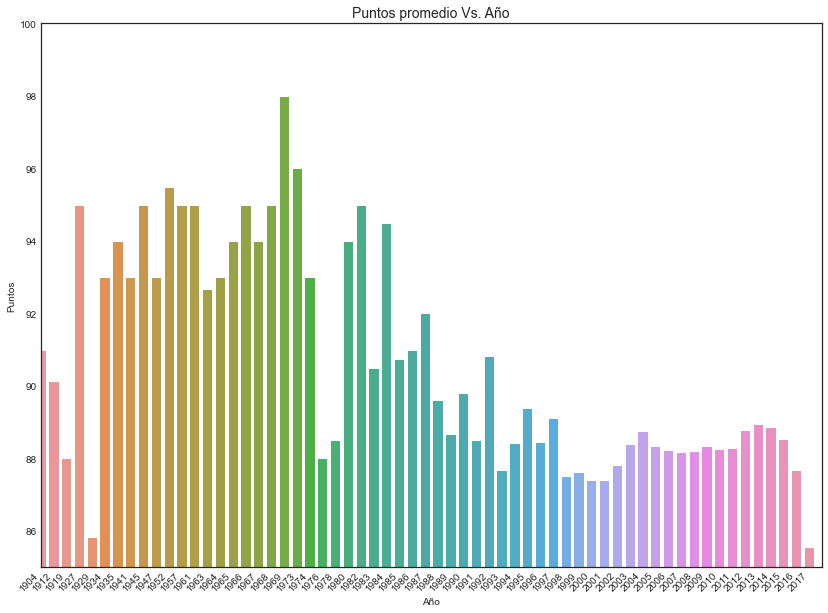

In [33]:
# Hacemos un gráfico de puntuación Vs. Año
#-----------------------------------------
import matplotlib.style as style

dsWineYear = ds.groupby(['year']).mean()
dsWineYear = pd.DataFrame(data=dsWineYear).reset_index(drop=False)

style.use("seaborn-white")
plt.figure(figsize=(14,10))
ax = sns.barplot(y=dsWineYear['points'], x=dsWineYear['year'])
plt.title("Puntos promedio Vs. Año", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Puntos")
ax.set(
    xlim=(0, len(dsWineYear)), 
    ylim=(85, 100)
)
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'
)

plt.show()

#=================================================================
# CONCLUSIÓN MIRANDO EL GRÁFICO: Vinos asentados puntúan más alto!
#  - Salvo 1978 y 1980 que no anduvieron bien...
#=================================================================

In [34]:
# No entiendo de dónde sale Unnamed: 0.1 (igual que no entendía el Unnamed:0 de antes)
ds.describe()

,Unnamed: 0,points,price,year
count,125283.000000,125283.000000,125283.000000,125283.000000
mean,65023.907992,88.485652,35.922131,2010.669660
std,37530.595342,3.040949,40.982752,3.797799
min,0.000000,80.000000,4.000000,1904.000000
25%,32512.500000,86.000000,17.100000,2009.000000
50%,65049.000000,88.000000,26.000000,2011.000000
75%,97533.500000,91.000000,42.000000,2013.000000
max,129970.000000,100.000000,3300.000000,2017.000000


## Exploración de datos
Una vez hecha la limpieza de datos empecemos a desentrañar la información que tenemos en nuestro dataset para elegir la mejor manera de utilizarla

In [35]:
# Veamos primero qué campos hay y de qué tipo de datos
ds.dtypes

Unnamed: 0       int64
country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
taster_name     object
title           object
variety         object
winery          object
year             int32
dtype: object

### Datos numéricos
Los datos numéricos son los más fáciles de entender. En principio con lo que contamos son la puntuación que le dió el enólogo en cuestión (points), el precio que tiene de mercado (price) y el año de cosecha (year) que fue el dato que agregamos obteniéndolo del título

### Viendo qué contienen los otros campos
Podemos echarle una mirada a los otros campos para ver qué es lo que tienen adentro y como para ir viendo si vamos a utilizar toda la información disponible o si hay información que termine complejizando, no agregando o siendo supérflua como para no considerarla

In [46]:
# Echemos una mirada a alguno de los datos categóricos (object)
ds["country"].value_counts()

US                        53585
France                    20511
Italy                     18544
Spain                      6133
Portugal                   5374
Chile                      4444
Argentina                  3755
Austria                    3304
Australia                  2260
Germany                    2149
New Zealand                1409
South Africa               1386
Israel                      504
Greece                      445
Canada                      256
Hungary                     143
Bulgaria                    141
Romania                     120
Uruguay                     108
Turkey                       90
Slovenia                     85
Georgia                      83
Croatia                      72
Mexico                       70
England                      59
Moldova                      57
Brazil                       41
Lebanon                      35
Morocco                      28
Peru                         16
Serbia                       12
Macedoni

##### Mini-conclusión
Como se puede ver la mayoría de los vinos calificados son de Estados Unidos, estando Argentina en el 6to lugar con menos del 10% de las calificaciones de US. Podríamos decir que los tres productores principales clasificados son Estados Unidos, Francia e Italia. Ya podemos ver que hay países de origen con sus vinos calificados que podríamos descartar para el análisis

In [47]:
#ds["variety"].value_counts()[:20]
ds["variety"].value_counts()

Pinot Noir                  13123
Chardonnay                  11469
Cabernet Sauvignon           9447
Red Blend                    8710
Bordeaux-style Red Blend     6901
                            ...  
Torontel                        1
Espadeiro                       1
Merlot-Shiraz                   1
Roussanne-Grenache Blanc        1
Mavroudi                        1
Name: variety, Length: 692, dtype: int64

##### Mini-conclusión
Hay demasiadas cepas, quizás debamos particionar el dataset en este aspecto

In [48]:
ds["taster_name"].value_counts()

Unknown               25159
Roger Voss            23867
Michael Schachner     14536
Kerin O’Keefe         10450
Virginie Boone         9432
Paul Gregutt           9416
Matt Kettmann          6298
Joe Czerwinski         5051
Sean P. Sullivan       4913
Anna Lee C. Iijima     4336
Jim Gordon             4017
Anne Krebiehl MW       3462
Lauren Buzzeo          1795
Susan Kostrzewa        1042
Mike DeSimone           500
Jeff Jenssen            453
Alexander Peartree      395
Carrie Dykes            134
Fiona Adams              22
Christina Pickard         5
Name: taster_name, dtype: int64

#### Mini-conclusión
La cantidad de sommeliers es manejable. Aunque se nota que hay muchos vinos que tienen calificador desconocido. Si la idea es obtener algún resultado relacionado con el sommelier deberíamos quitar esas entradas del dataset. (esto es tratado más adelante)

In [124]:
ds["winery"].value_counts()

Wines & Winemakers           221
Testarossa                   218
DFJ Vinhos                   215
Williams Selyem              211
Louis Latour                 199
                            ... 
Domaine de la Graveirette      1
Gordonzello                    1
Org de Rac                     1
PV Vinhos                      1
Escalera                       1
Name: winery, Length: 16334, dtype: int64

#### Mini-conclusión
La cantidad de bodegas es monstruosa. Habrá que ver también cómo utilizar este dato, más que nada pensando en la codificación de este dato categórico

In [49]:
ds["province"].value_counts()

California        35635
Washington         8565
Bordeaux           5937
Tuscany            5894
Oregon             5334
                  ...  
Kentucky              1
Dingač                1
Santa Catarina        1
Urla-Thrace           1
Lesbos                1
Name: province, Length: 419, dtype: int64

#### Mini-conclusión
También hay demasiadas provincias. Idem conclusión anterior.

#### Analicemos un poco qué pasa con los sommeliers
La idea es evaluar puntualmente este campo y ver cómo se comportan los sommeliers

In [50]:
# Veamos cómo puntúan:
#---------------------
agg_op1 = ds.groupby('taster_name').agg({
    'points': 'mean',
    'price': 'mean',
    'variety': 'count'
})
agg_op1.columns = ['mean_points','mean_price','frequency']
agg_op1.sort_values(by='frequency', ascending=False)

,mean_points,mean_price,frequency
taster_name,,,
Unknown,87.875591,37.419937,25159
Roger Voss,88.725227,39.671463,23867
Michael Schachner,86.919441,25.357347,14536
Kerin O’Keefe,88.904115,41.807617,10450
Virginie Boone,89.224767,46.788953,9432
Paul Gregutt,89.105140,33.749915,9416
Matt Kettmann,90.014925,38.524547,6298
Joe Czerwinski,88.555930,35.063710,5051
Sean P. Sullivan,88.776308,34.237472,4913


#### Mini-conclusión
Como se ve Roger Voss es el sommelier que más calificaciones hizo dando un promedio de 89 puntos sobre 100, sobre vinos que tienen un valor promedio de USD39. El sommelier que más puntaje dio a los vinos que evaluó es Anne Krebiehl dando un puntaje promedio de 90.64/100 en vinos de valor promedio USD31.45

In [151]:
# Veamos ahora 
agg_op2 = ds.groupby(['taster_name','variety']).agg({
    'points':'mean',
    'price':'mean'
})
agg_op2.columns = ['mean_points','mean_price']
idmaxmin = agg_op2.groupby("taster_name").agg({"mean_points": ['idxmax', 'idxmin']})

tastermaxmin = pd.DataFrame(columns=['taster_name'], data=idmaxmin.index.values)
tastermaxmin['most_rated'] = idmaxmin.iloc[:,0].apply(lambda x: x[1]).values
tastermaxmin['least_rated'] = idmaxmin.iloc[:,1].apply(lambda x: x[1]).values
tastermaxmin

,taster_name,most_rated,least_rated
0,Alexander Peartree,Touriga,G-S-M
1,Anna Lee C. Iijima,Riesling-Chardonnay,Mavrud
2,Anne Krebiehl MW,Gelber Traminer,Cabernet Sauvignon
3,Carrie Dykes,Meritage,Riesling
4,Christina Pickard,Shiraz,Sauvignon Blanc
5,Fiona Adams,Cabernet Franc,Red Blend
6,Jeff Jenssen,Tokaji,Saperavi
7,Jim Gordon,Champagne Blend,Fumé Blanc
8,Joe Czerwinski,Cabernet-Shiraz,Cabernet Franc
9,Kerin O’Keefe,Roviello,Asprinio


#### Mini-conclusión
Basado en lo anterior podemos decir que a Roger Voss el vino que más le gusta es el Terrantez (ojo, este es un vino de Madeira, Portugal. No tiene nada que ver con el Torrontés Argentino) y el que menos le gusta es el Gewürztraminer-Riesling (coincido, gusto a nada). A su vez a Anne Krebiehl el que más le gusta es el Gelber Traminer y el que menos es el Cabernet Sauvignon (que amarga que sos Anne! =) )

## Preparación de datos

En base a la exploración de datos realizada podemos ver que tenemos muchísimos y diversos datos y por lo tanto varias manera de relacionarlos. Para este trabajo vamos a elegir un subset reducido que nos permita trabajar de manera más sencilla con los mismos. Elegiremos un único varietal (Cabernet Sauvignon) y solo algunos campos puntuales:

- __Salida:__ 
    - Puntaje (points): Hay que elegir una/s salida/s para el análisis. Por lógica esta podría ser tanto precio como puntos otorgados por el sommelier. Empezamos seleccionando puntos ya que en algún momento vamos a querer ver si hay una relación entre el puntaje que recibe un vino y su precio en góndola...o vinoteca.
- __Entradas:__ Podríamos haber elegido otras o más variantes. Pero empezaremos por estas a ver qué relaciones encontramos.
    - Precio (price)
    - Sommelier (taster_name)
    - País (country)
    - Año (year)
<br> 

A su vez, dentro de nuestro dataset tenemos tanto variables continuas como categóricas. Para poder tratarlas en una estructura de árbol debemos convertir esas variables categóricas de alguna manera en numéricas. Hay varias aproximaciones a resolver este problema (me ayudó mucho leer del siguiente enlace: https://pbpython.com/categorical-encoding.html). La primer prueba fue realizar un one-hot-encoding, pero el número de variables agregadar por cada característica se hacía inmanejable en relación a los recursos de memoria (y entendimiento). Una aproximación mucho mejor, inclusive desde la lógica de lo que estamos buscando resolver es utilizar es hacer un encoding por diccionario.

In [36]:
# Vayamos con las entradas
#-------------------------

# Recordemos que nos queremos quedar únicamente con la cepa Cabernet Sauvignon para hacer el análisis
# sobre la misma
cabernet_data = ds.query("variety == 'Cabernet Sauvignon'")[['points','price','taster_name','country','year']]

# Vemos cómo quedó...
cabernet_data.dtypes

points           int64
price          float64
taster_name     object
country         object
year             int32
dtype: object

#### Mini-conclusión

Tenemos finalmente (porque los elegimos). Dos características categóricas y tres numéricas. De las tres numéricas una será la salida (puntuación)

### Miremos un poco la data segregada para esta cepa

In [65]:
# Un análisis rápido de las columnas numéricas
cabernet_data.describe()

,points,price,year
count,9447.000000,9447.000000,9447.000000
mean,88.616704,47.880364,2009.624643
std,3.312937,41.045081,3.693374
min,80.000000,4.000000,1985.000000
25%,86.000000,20.000000,2007.000000
50%,88.000000,37.000000,2010.000000
75%,91.000000,65.000000,2012.000000
max,100.000000,625.000000,2016.000000


#### Mini-conclusión
- Las puntuaciones van de 80 a 100 (con el 75 percentil en 91)
- Los precios van de 4USD a 625USD (con el 75 percentil en 65 USD)
- Los años van de 1985 a 2016 (con el 75 percentil en el 2012)

(array([ 120.,  418., 1188., 1979., 1759., 1982., 1344.,  553.,   86.,
          18.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 10 Patch objects>)

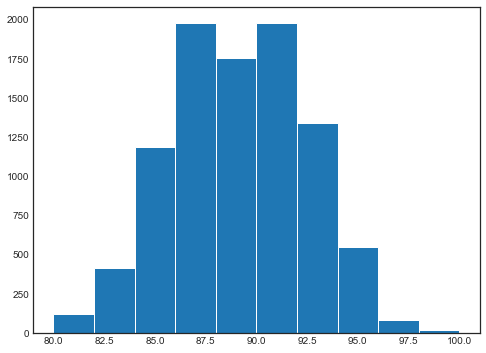

In [66]:
# Ahora miremos más en detalle la forma de la distribución de salida (puntaje)
points = cabernet_data.points.to_numpy()
fig, ax = plt.subplots(1,figsize=(8,6))
ax.hist(points)

#### Mini-conclusión
Se ve que el puntaje tiene una distribución que se asemeja a una gaussiana. <br> 

__NOTA:__ Lo que vamos a hacer para simplificar es transformar esta variable en binaria. Vinos menores que la media (88pts) serán de calidad baja y vinos mayores que la media de calidad alta

In [37]:
cabernet_data['binary_points'] = cabernet_data.points.apply(lambda label: 0 if (label <= 88) else 1)

# Nos fijamos cuántos quedan en cada clase
print(cabernet_data[cabernet_data['binary_points'] == 0].shape)
print(cabernet_data[cabernet_data['binary_points'] == 1].shape)

# Queda bastante balanceado, tal como esperábamos

(4767, 6)
(4680, 6)


(array([2229., 2735., 1805., 1177.,  658.,  254.,  240.,  143.,   72.,
          62.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <a list of 10 Patch objects>)

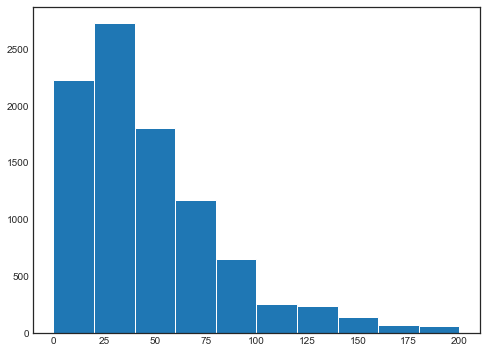

In [68]:
# Veamos también (para chusmear) cómo es la distribución de precios. Recordemos que el 75 percentil
# estaba en 65 USD, esto quiere decir que por más que el valor máximo esté en 625 USD los precios
# están concentrados en valores bajos. Limitamos el histograma entonces a vinos de hasta 200 USD.
price = cabernet_data.price.to_numpy()
fig, ax = plt.subplots(1,figsize=(8,6))
ax.hist(price,10,[0,200])

In [60]:
# Recordemos que muchos de las entradas tenían taster_name = 'unknown'. Como queremos hacer un análisis
# basado también en los sommeliers nos embarra un poco la cancha no saber quién es el que terminó dando
# el puntaje, por lo que mejor eliminamos esas entradas
#------------------------------------------------------
# Encuentro los índices

#indexUnknown = cabernet_data[ cabernet_data['taster_name'] == 'Unknown' ].index
#cabernet_data.drop(indexUnknown , inplace=True)

#cabernet_data["taster_name"].value_counts()

#### NOTA ACLARATORIA: 
En un principio pensé eliminar estas entradas (es decir, los sommelier desconocidos). Pero la verdad son muchos (y valiosos) datos para otro tipo de análisis más allá de quién fue el sommelier involucrado en la calificación

### Variables categóricas
Tenemos dos variables que son categóricas (taster_name y country). notamos que hay algunos países que tienen pocas entradas y algunos sommeliers que calificaron pocos vinos. Por lo tanto elegimos quedarnos con los doce primeros países y con los 15 primeros sommeliers que tienen mayores entradas de cada característica.

In [69]:
cabernet_data["country"].value_counts()

US              7300
Chile            769
Argentina        540
Australia        266
South Africa     132
Italy            130
Israel           105
France            53
Spain             52
Bulgaria          20
Romania           16
Portugal          16
Moldova            8
Mexico             8
Canada             7
Greece             6
Austria            5
Brazil             4
Slovenia           3
Turkey             2
Uruguay            2
New Zealand        2
Ukraine            1
Name: country, dtype: int64

In [70]:
cabernet_data["taster_name"].value_counts()

Unknown               3197
Virginie Boone        1826
Michael Schachner     1354
Sean P. Sullivan       785
Paul Gregutt           676
Matt Kettmann          454
Jim Gordon             394
Joe Czerwinski         263
Lauren Buzzeo          138
Anna Lee C. Iijima      91
Susan Kostrzewa         67
Mike DeSimone           65
Roger Voss              47
Jeff Jenssen            35
Kerin O’Keefe           32
Alexander Peartree       8
Carrie Dykes             7
Fiona Adams              6
Anne Krebiehl MW         2
Name: taster_name, dtype: int64

In [38]:
# Tenemos estos dos campos que son categóricos. Tenemos que encontrar alguna manera de codificarlos
# pero también notamos que hay algunos países que tienen pocas entradas y algunos sommeliers que
# calificaron pocos vinos. Por lo tanto elegimos quedarnos con los doce primeros que tienen mayores
# entradas de cada característica.
#-----------------------------------------------------------------------
# Encuentro los índices
indexDrop1 = cabernet_data[(cabernet_data['taster_name'] == 'Alexander Peartree') |
                           (cabernet_data['taster_name'] == 'Carrie Dykes') |
                           (cabernet_data['taster_name'] == 'Fiona Adams') |
                           (cabernet_data['taster_name'] == 'Anne Krebiehl MW')].index

# Elimino
cabernet_data.drop(indexDrop1 , inplace=True)

# Encuentro los índices
indexDrop2 = cabernet_data[ (cabernet_data['country'] == 'Moldova') |
                          (cabernet_data['country'] == 'Mexico') |
                          (cabernet_data['country'] == 'Canada') |
                          (cabernet_data['country'] == 'Greece') |
                          (cabernet_data['country'] == 'Austria') |
                          (cabernet_data['country'] == 'Brazil') |
                          (cabernet_data['country'] == 'Slovenia') |
                          (cabernet_data['country'] == 'New Zealand') |
                          (cabernet_data['country'] == 'Turkey') |
                          (cabernet_data['country'] == 'Uruguay') |
                          (cabernet_data['country'] == 'Ukraine')].index

# Elimino
cabernet_data.drop(indexDrop2 , inplace=True)

print(cabernet_data["taster_name"].value_counts())
print('\n')
print(cabernet_data["country"].value_counts())

# NOTA: Como se ve más abajo cambian los cuentas de sommeliers y países (aunque muy marginalmente).
# Esto se debe a que por ejemplo al eliminar filas de un país específico (por ejemplo New Zealand)
# también podemos estar eliminando algún registro de los sommeliers que queríamos mantener. No
# obstante, como dicho, es marginal.

Unknown               3196
Virginie Boone        1826
Michael Schachner     1341
Sean P. Sullivan       784
Paul Gregutt           672
Matt Kettmann          454
Jim Gordon             394
Joe Czerwinski         261
Lauren Buzzeo          138
Anna Lee C. Iijima      88
Mike DeSimone           64
Susan Kostrzewa         60
Roger Voss              44
Kerin O’Keefe           32
Jeff Jenssen            24
Name: taster_name, dtype: int64


US              7279
Chile            769
Argentina        540
Australia        266
South Africa     132
Italy            130
Israel           105
France            53
Spain             52
Bulgaria          20
Romania           16
Portugal          16
Name: country, dtype: int64


#### Codificación de las variables categóricas

- En un principio pensé en hacer una categorización de país y sommelier como se muestra abajo, asignando un código numérico a cada uno. Esto también tenía que ver con que al principio pensaba usar todas las variables, incluida por ejemplo "province" y dada la alta cardinalidad de dichas variables pensar en una codificación one-hot-encoding se hacía imposible. <br>
- El problema con codificar asignando códigos numéricos tiene que ver con asignar mayor importancia a los números altos más que a los bajos (particularmente notorio en el caso de redes neuronales) por lo tanto y dado que restringimos el número de casos en cada variable categórica, vamos a utilizar la codificación one-hot-encoding.

In [24]:
# Ahora hacemos el encoding por el método de categorías
#------------------------------------------------------
#cabernet_data["country"] = cabernet_data["country"].astype('category')
#dict_country = dict(enumerate(cabernet_data["country"].cat.categories))
#cabernet_data["country"] = cabernet_data["country"].cat.codes

#cabernet_data["taster_name"] = cabernet_data["taster_name"].astype('category')
#dict_taster = dict(enumerate(cabernet_data["taster_name"].cat.categories))
#cabernet_data["taster_name"] = cabernet_data["taster_name"].cat.codes

#cabernet_data.head(20)

,points,price,taster_name,country,year
8,90,25.0,11,11,2013
27,85,18.0,7,11,2010
58,88,25.0,9,11,2013
131,90,90.0,11,11,2012
170,89,50.0,11,11,2011
172,91,35.0,7,11,2009
182,92,45.0,2,1,2012
201,82,25.0,11,11,2013
209,86,14.0,5,0,2014
215,90,12.0,5,3,2001


In [27]:
# Diccionarios de variables categóricas
#print('Diccionario de Países:',dict_country)
#print('\n')
#print('Diccionario de Sommeliers:',dict_taster)

Diccionario de Países: {0: 'Argentina', 1: 'Australia', 2: 'Bulgaria', 3: 'Chile', 4: 'France', 5: 'Israel', 6: 'Italy', 7: 'Portugal', 8: 'Romania', 9: 'South Africa', 10: 'Spain', 11: 'US'}


Diccionario de Somelliers: {0: 'Anna Lee C. Iijima', 1: 'Jim Gordon', 2: 'Joe Czerwinski', 3: 'Lauren Buzzeo', 4: 'Matt Kettmann', 5: 'Michael Schachner', 6: 'Mike DeSimone', 7: 'Paul Gregutt', 8: 'Roger Voss', 9: 'Sean P. Sullivan', 10: 'Susan Kostrzewa', 11: 'Virginie Boone'}


In [39]:
### One hot encoding
country_dummies = pd.get_dummies(cabernet_data.country, prefix='country')
taster_dummies = pd.get_dummies(cabernet_data.taster_name, prefix='taster')

In [80]:
# Armamos el dataset final
final_ds = pd.concat([country_dummies, taster_dummies, cabernet_data.year, cabernet_data.price, cabernet_data.binary_points, cabernet_data.points], axis=1)

In [81]:
# Vemos cómo quedó la cosa
final_ds.head(5)
print(final_ds.dtypes)

country_Argentina              uint8
country_Australia              uint8
country_Bulgaria               uint8
country_Chile                  uint8
country_France                 uint8
country_Israel                 uint8
country_Italy                  uint8
country_Portugal               uint8
country_Romania                uint8
country_South Africa           uint8
country_Spain                  uint8
country_US                     uint8
taster_Anna Lee C. Iijima      uint8
taster_Jeff Jenssen            uint8
taster_Jim Gordon              uint8
taster_Joe Czerwinski          uint8
taster_Kerin O’Keefe           uint8
taster_Lauren Buzzeo           uint8
taster_Matt Kettmann           uint8
taster_Michael Schachner       uint8
taster_Mike DeSimone           uint8
taster_Paul Gregutt            uint8
taster_Roger Voss              uint8
taster_Sean P. Sullivan        uint8
taster_Susan Kostrzewa         uint8
taster_Unknown                 uint8
taster_Virginie Boone          uint8
y

In [82]:
# Ya que tenemos el dataset final lo salvamos a disco por si empiezo desde acá
#=============================================================================
final_ds.to_csv('final_ds.csv')

In [3]:
# --> PUNTO DE RE-ARRANQUE (para no hacer todo lo demás)

# Levantamos el archivo
final_ds = pd.read_csv('final_ds.csv')

### Separación y normalización de datos

In [83]:
# Como dijimos la salida va a ser el puntaje
#-------------------------------------------
y = final_ds['binary_points']

In [89]:
# Para los X solo tengo que descartar las salidas
#------------------------------------------------
X = final_ds.drop(['binary_points','points'], axis=1)

In [90]:
# 7. Hacemos un split en training (70%), validation (20%) y testing (10%). 

# Armamos el vector de barajado
n_samples = X.shape[0]
indexes = np.random.permutation(np.arange(0, n_samples))

# Obtenemos los índices del "split" de datos: 70 - 20 - 10
train_idx = indexes[0:int(0.7*n_samples)]
validation_idx = indexes[int(0.7*n_samples): int(0.9*n_samples)]
test_idx = indexes[int(0.9*n_samples):]

# Chequeamos que anduvo bien
assert n_samples == train_idx.size + validation_idx.size + test_idx.size

# Armamos los sets de entrenamiento...
x_train = X.iloc[train_idx,:]
y_train = y.iloc[train_idx].to_numpy()

# ...validación...
x_validation = X.iloc[validation_idx,:]
y_validation = y.iloc[validation_idx].to_numpy()

# ...y test
x_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx].to_numpy()

## Visualización de la información en árboles

In [91]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from dtreeviz.trees import dtreeviz # remember to load the package

In [92]:
print(y.shape)
print(X.shape)

(9378,)
(9378, 29)


|--- feature_28 <= 28.70
|   |--- feature_28 <= 19.50
|   |   |--- feature_28 <= 14.50
|   |   |   |--- feature_2 <= 0.50
|   |   |   |   |--- feature_28 <= 11.50
|   |   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |   |   |   |--- feature_28 <= 10.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_28 >  10.50
|   |   |   |   |   |   |   |   |   |--- feature_27 <= 2009.50
|   |   |   |   |   |   |   |   |   |   |--- feature_27 <= 2008.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_27 >  2008.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_27 >  2009.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   

IndexError: list index out of range

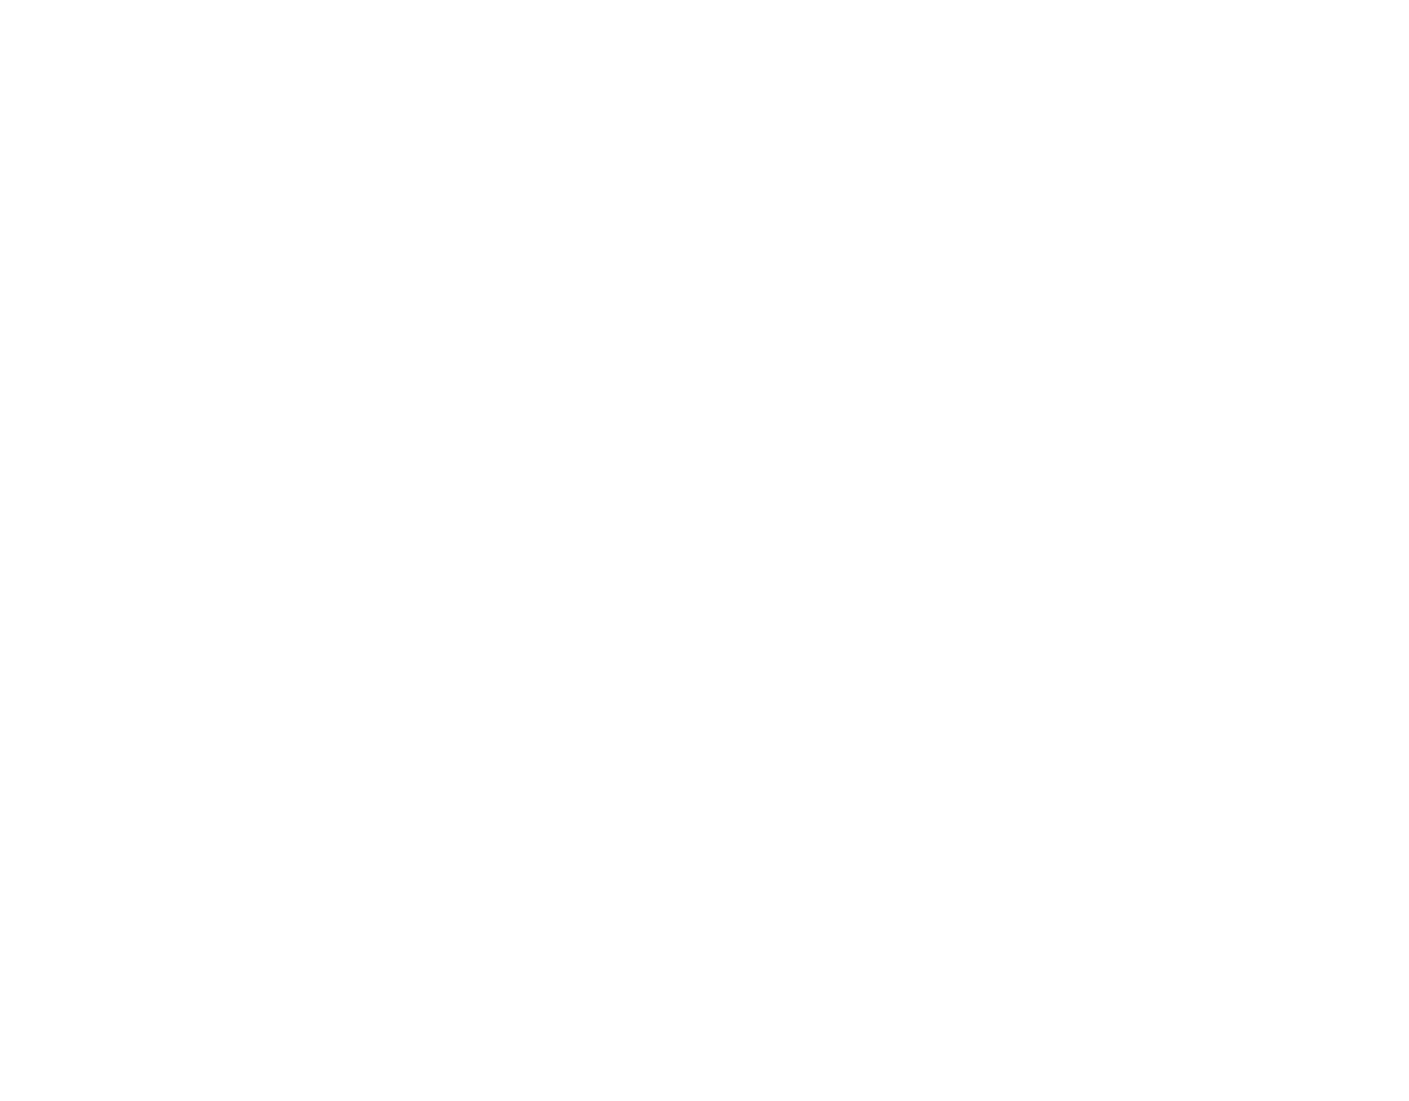

In [93]:
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(x_train, y_train)

#Print Text Representation
#Exporting Decision Tree to the text representation can be useful when 
#working on applications whitout user interface or when we want to log information about the model into the text file.

text_representation = tree.export_text(clf)
print(text_representation)

with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)

#Plot Tree with plot_tree

#The plot_tree method was added to sklearn in version 0.21. It requires matplotlib 
#to be installed. It allows us to easily produce figure of the tree (without intermediate exporting to graphviz)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(X.columns),
                   class_names = list(['points']),
                   filled=False)

fig.savefig("decision_tree.png")

#### Sobre el error de la celda anterior:
Me tira error al intentar armar el gráfico del árbol y no llego a entender por qué. Le di vueltas y vueltas y las dimensiones me parecen bien. No llego a pescar el error...

## Modelo base
Hacemos primero un modelo base para comparar. Cualquier otro modelo que implementemos tiene que andar mejor que este. <br>
Lo que asume este modelo base es que siempre predice lo mismo (es un approach clásico para clasificación binaria)

In [94]:
class BiasModel(object):

    def fit(self, X, y):
        return None

    def predict(self, X):
        return np.ones(X.shape[0])

In [95]:
bias_model = BiasModel()
bias_model.fit(x_train, y_train)
bm_predictions = bias_model.predict(x_validation)

In [96]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_validation, bm_predictions)
print(metrics.auc(fpr, tpr))

0.5


NOTA: Como era de esperar, el AUC da 0.5, como un caso de clasificación aleatorio.

## Random Forest
Corremos un random forest a ver si es capaz de predecir la salida (puntaje) en función de los demás parámetros.

In [97]:
# Corremos un modelo de random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 

# Vamos primero con la parametrización por defecto (notamos que no tiene sentido agregar mucho más de 10 árboles)
rf_model = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=100)
rf_model.fit(x_train, y_train)

y_predict = rf_model.predict(x_validation)
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: ", confusion_matrix(y_validation, y_predict))
print ("Accuracy Validation : ", accuracy_score(y_validation,y_predict)*100)

y_predict = rf_model.predict(x_test)
print ("Accuracy Test : ", accuracy_score(y_test,y_predict)*100)

AUC:  0.7296521541434581
Confusion Matrix:  [[669 257]
 [250 700]]
Accuracy Validation :  72.97441364605544
Accuracy Test :  74.52025586353945


In [98]:
# Probemos ahora tuneando un poco...
rf_model = RandomForestClassifier(n_estimators=21, max_depth=10, random_state=100)
rf_model.fit(x_train, y_train)

y_predict = rf_model.predict(x_validation)
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: ", confusion_matrix(y_validation, y_predict)) 
print ("Accuracy : ", accuracy_score(y_validation,y_predict)*100)

y_predict = rf_model.predict(x_test)
print ("Accuracy Test : ", accuracy_score(y_test,y_predict)*100)

AUC:  0.7525781516426053
Confusion Matrix:  [[652 274]
 [189 761]]
Accuracy :  75.31982942430704
Accuracy Test :  77.50533049040513


In [99]:
# Probemos con otro criterio de discriminación (entropía)
rf_model = RandomForestClassifier(n_estimators=21, criterion = "entropy", max_depth=9, random_state=100)
rf_model.fit(x_train, y_train)

y_predict = rf_model.predict(x_validation)
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: ", confusion_matrix(y_validation, y_predict)) 
print ("Accuracy : ", accuracy_score(y_validation,y_predict)*100)

y_predict = rf_model.predict(x_test)
print ("Accuracy Test : ", accuracy_score(y_test,y_predict)*100)

AUC:  0.7564396953506879
Confusion Matrix:  [[665 261]
 [195 755]]
Accuracy :  75.69296375266525
Accuracy Test :  76.65245202558634


#### Mini-conclusión
1. La versión por defecto ya funciona bastante mejor que el modelo de base. Llevando el accuracy al 72%. Aumentar el número de árboles no presenta mejoras sustanciales.
- Luego cambiamos el número de árboles a 21 y la profundidad máxima a 10. Estos valores que parecen caprichosos (medio que lo son) llevan el accuracy al 75%. No es una mejora sustancial pero es algo. Lo interesante es que con más o menos árboles, o más o menos profundidad la métrica cae. Estimo que hay un modelo de árboles óptimo para cada problema. Aunque Random Forest use la técnica de Bagging, habrá que ver si se vuelven a barajar los datos para obtener un train set distinto.
- Cambiar el criterio de selección a entropía no presenta mejoras sustanciales. Siendo así nos quedaríamos con el criterio de Gini, el cual dado que no precisa calcular el logaritmo involucra menor tiempo de cómputo.
- Los modelos andan bien sobre el Test set. Todo indicaría que no hay overfitting
- No es necesario normalizar los datos como en el caso de su utilización en redes
- Somos mejor que el caso aleatorio....pero aún así no es un accuracy muy elevado (~75%) como para poder determinar el puntaje (vino de calidad baja/alta) en función de los parámetros restantes

## Árboles de regresión

Podemos usar árboles también para realizar regresiones (aunque no es lo más común). Vamos a elegir dos casos para mostrar esto:

- Precio Vs. Puntaje
- Precio Vs. Año


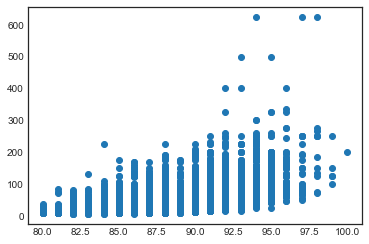

In [188]:
# Seleccionamos el puntaje pero no binarizado
x_regression = final_ds[['points']]

# Seleccionamos el precio
y_regression = final_ds['price']

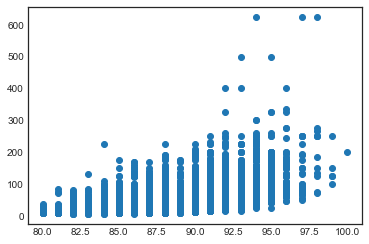

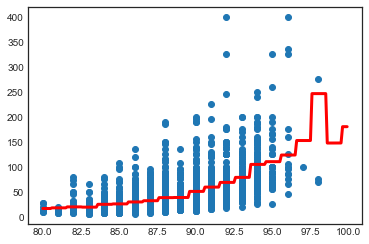

MODELO DE ÁRBOL DE REGRESIÓN

Precisión del modelo:
0.3729104394350552


In [196]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(x_regression, y_regression, test_size=0.2)

#Defino el algoritmo a utilizar
bar = RandomForestRegressor(n_estimators = 100, max_depth = 10)

#Entreno el modelo
bar.fit(X_train, y_train)

#Realizo una predicción
Y_pred = bar.predict(X_test)

#Graficamos los datos correspondientes
plt.scatter(x_regression, y_regression)
plt.show()

#Graficamos los datos de prueba junto con la predicción
#X_grid = np.arange(min(X_test), max(X_test), 0.1)
X_grid = np.arange(80, 100, 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_test, y_test)
plt.plot(X_grid, bar.predict(X_grid), color='red', linewidth=3)
plt.show()

#
print('MODELO DE ÁRBOL DE REGRESIÓN')
print()
print('Precisión del modelo:')
print(bar.score(X_train, y_train))

In [214]:
# Seleccionamos el puntaje pero no binarizado
x_regression = final_ds[['year']]

# Seleccionamos el precio
y_regression = final_ds['price']

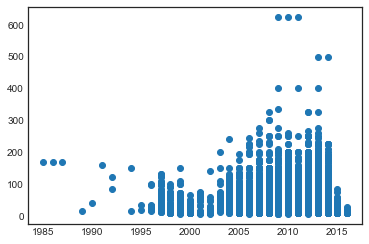

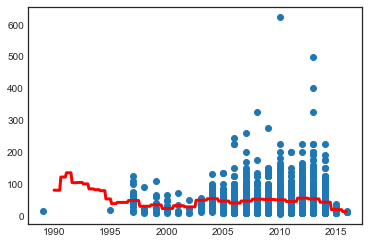

MODELO DE ÁRBOL DE REGRESIÓN

Precisión del modelo:
0.03528416412188917


In [229]:
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(x_regression, y_regression, test_size=0.2)

#Defino el algoritmo a utilizar
bar = RandomForestRegressor(n_estimators = 300, max_depth = 15)

#Entreno el modelo
bar.fit(X_train, y_train)

#Realizo una predicción
Y_pred = bar.predict(X_test)

#Graficamos los datos correspondientes
plt.scatter(x_regression, y_regression)
plt.show()

#Graficamos los datos de prueba junto con la predicción
#X_grid = np.arange(min(X_test), max(X_test), 0.1)
X_grid = np.arange(1990, 2016, 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_test, y_test)
plt.plot(X_grid, bar.predict(X_grid), color='red', linewidth=3)
plt.show()

#
print('MODELO DE ÁRBOL DE REGRESIÓN')
print()
print('Precisión del modelo:')
print(bar.score(X_train, y_train))

#### Mini-conclusión

- En el primer caso (Precio Vs. Puntaje) hay una regresión razonable, aunque el accuracy es muy bajo, solo del 37%.
- En el segundo caso (Precio Vs. Año) la regresión no da nada bien. No llego a entender por qué...mirando el scatter de datos la pendiente de la curva de ajuste debería dar al revés. Por otro lado acá sí el accuracy es definitivamente malo.
- Es probable que estos no sean casos para aplicar regresiones lineales con árboles
- Por la manera de armar x_regression e y_regression y luego hacer el split me terminan quedando un X_test, y_test, etc que son dataframe de Pandas. Luego no puedo utilizar min(X_test) y max(X_test) para armar el X_grid. Tampoco me anduvo intentando sacar valores máximos y mínimos de X_test con pandas...por eso está X_grid harcodeado.

### Regresión logística

El método de regresión logística se aplica a casos de clasificación binaria y se basa en la aplicación del concepto de máxima verosimilitud para estimar los coeficientes que determinan la probabilidad de pertenecer a una clase u otra. <br>


In [230]:
# Vamos a volver a utilizar los datos con los que probamos el Random Forest
y = final_ds['binary_points']
X = final_ds.drop(['binary_points','points'], axis=1)

In [231]:
# Hacemos el split

# Armamos el vector de barajado
n_samples = X.shape[0]
indexes = np.random.permutation(np.arange(0, n_samples))

# Obtenemos los índices del "split" de datos: 70 - 20 - 10
train_idx = indexes[0:int(0.7*n_samples)]
validation_idx = indexes[int(0.7*n_samples): int(0.9*n_samples)]
test_idx = indexes[int(0.9*n_samples):]

# Chequeamos que anduvo bien
assert n_samples == train_idx.size + validation_idx.size + test_idx.size

# Armamos los sets de entrenamiento...
x_train = X.iloc[train_idx,:]
y_train = y.iloc[train_idx].to_numpy()

# ...validación...
x_validation = X.iloc[validation_idx,:]
y_validation = y.iloc[validation_idx].to_numpy()

# ...y test
x_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx].to_numpy()

In [232]:
# Ahora normalizamos el set de datos
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [234]:
# Construímos el modelo de regresión logística (incluye el parámetro de regularización C)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.01, multi_class='warn', solver='liblinear')

In [237]:
# Ajustado el modelo podemos realizar predicciones sobre el test set:
yhat = LR.predict(x_test)
yhat[:20]

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
      dtype=int64)

In [239]:
# También podemos ver "más adentro" (o antes de la sigmoidea) y ver la probabilidad de cada fila
# de pertenecer a una clase (P(Y=1|X), primer columna) o a la otra (P(Y=0|X), segunda columna)
yhat_prob = LR.predict_proba(x_test)
yhat_prob[:20]

array([[0.75638872, 0.24361128],
       [0.736664  , 0.263336  ],
       [0.29974231, 0.70025769],
       [0.53802221, 0.46197779],
       [0.06137549, 0.93862451],
       [0.81255795, 0.18744205],
       [0.78450779, 0.21549221],
       [0.83202329, 0.16797671],
       [0.76524422, 0.23475578],
       [0.34893597, 0.65106403],
       [0.50537589, 0.49462411],
       [0.07716894, 0.92283106],
       [0.77682025, 0.22317975],
       [0.84902718, 0.15097282],
       [0.41335496, 0.58664504],
       [0.59471148, 0.40528852],
       [0.68421969, 0.31578031],
       [0.45374253, 0.54625747],
       [0.53163925, 0.46836075],
       [0.74165672, 0.25834328]])

Matriz de confusión sin normalización
[[293 163]
 [101 381]]


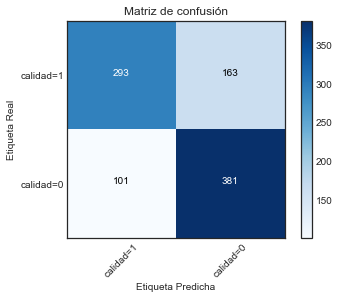

In [246]:
# Finalmente podemos realizar una evaluación más detallada de la capacidad de predicción del modelo
# a través de la graficación de la matriz de confusión.

from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusión', cmap=plt.cm.Blues):
  """
  Esta función muestra y dibuja la matriz de confusión.
  La normalización se puede aplicar estableciendo el valor `normalize=True`.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Matriz de confusión normalizada")
  else:
    print('Matriz de confusión sin normalización')
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# Calcular la matriz de confusión
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Dibujar la matriz de confusión no normalizada
plt.figure()
plt.tight_layout()
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')

plot_confusion_matrix(cnf_matrix, classes=['calidad=1','calidad=0'],normalize= False, title='Matriz de confusión')

#### Mini-conclusión
- 'calidad = 1' se refiere a vinos de alta calidad y 'calidad = 0' a vinos de baja 
- Se ve que tanto en en los TP como los TN tenemos acumulados la mayor cantidad de eventos. Eso está bien, quiere decir que el modelo está prediciendo correctamente
- Hay un número no despreciable de FP donde el modelo se está confundiendo. Se confunde más que en el caso de FN que tampoco es despreciable. Podríamos resumirlo en que (con este modelo) tenemos un 20% (101/(101+381)) de chances de tomarnos un vino de baja de calidad catalogado como uno de alta, y también tenemos un 35% (163/(293+163)) de llevarnos una linda sorpresa tomándonos un vino de alta calidad que fue catalogado como de baja. Si somos amigos de la sorpresa (y posibles consumidores) es un buen modelo, si somos vendedores de vino y lucramos con los vinos de alta calidad todavía habría que ajustarlo, o cambiar de modelo.

### Support Vector Machines (SVM)

Las SVMs permiten también separar poblaciones y lo hacen a través de lo que se conoce como "vectores de soportes", los cuales no son más que muestras del set de entrenamiento que están justo en el borde de separación de las poblaciones. Para no quedarse únicamente en el caso de separación lineal es que este algoritmo hace uso de un producto interno que surge de la matemática involucrada y que permite incluir el concepto de Kernel, el cual permite realizar un remapeo de los datos a un espacio de mayor dimensión donde las poblaciones sí sean separables. Veamos cómo funciona esto con nuestro set de datos (iremos probando los distintos tipos de kernel para separar).

In [261]:
# Empecemos por el caso más simple, una separación lisa y llana lineal

from sklearn.svm import SVC

svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[380 102]
 [163 293]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       482
           1       0.74      0.64      0.69       456

    accuracy                           0.72       938
   macro avg       0.72      0.72      0.72       938
weighted avg       0.72      0.72      0.72       938



In [270]:
# Ahora probemos con una polinómica (que tiene por característica permitir separar cosas no 
# linealmente separables). Probando llegamos a una performance razonable con grado 3. Aún así
# funcionando peor que el modelo lineal

svclassifier = SVC(kernel='poly', degree=9)
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[386  96]
 [186 270]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       482
           1       0.74      0.59      0.66       456

    accuracy                           0.70       938
   macro avg       0.71      0.70      0.69       938
weighted avg       0.71      0.70      0.70       938



In [285]:
# Ahora intentemos un kernel gaussiano
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[427  55]
 [250 206]]
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       482
           1       0.79      0.45      0.57       456

    accuracy                           0.67       938
   macro avg       0.71      0.67      0.66       938
weighted avg       0.71      0.67      0.66       938



In [251]:
svclassifier = SVC(kernel='sigmoid', degree=8)
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[477   5]
 [399  57]]
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       482
           1       0.92      0.12      0.22       456

    accuracy                           0.57       938
   macro avg       0.73      0.56      0.46       938
weighted avg       0.73      0.57      0.47       938



#### Margen suave
Probemos ahora tocando algunos hiperparámetros. Principalmente el que relaja (permite muestras) dentro del margen.

In [304]:
# Parametrizando un poco el modelo con kernel polinómico
svclassifier = SVC(kernel='poly', degree=9, C = 2.5, coef0 = 0.0)
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[382 100]
 [174 282]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       482
           1       0.74      0.62      0.67       456

    accuracy                           0.71       938
   macro avg       0.71      0.71      0.70       938
weighted avg       0.71      0.71      0.71       938



In [314]:
# Parametrizando un poco el modelo con kernel sigmoid
svclassifier = SVC(kernel='sigmoid', C = 10.5, coef0 = 0.0)
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[405  77]
 [208 248]]
              precision    recall  f1-score   support

           0       0.66      0.84      0.74       482
           1       0.76      0.54      0.64       456

    accuracy                           0.70       938
   macro avg       0.71      0.69      0.69       938
weighted avg       0.71      0.70      0.69       938



In [316]:
# Parametrizando el modelo lineal
svclassifier = SVC(kernel='linear', C = 4.5)
svclassifier.fit(x_train, y_train)

y_hat = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

[[385  97]
 [165 291]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       482
           1       0.75      0.64      0.69       456

    accuracy                           0.72       938
   macro avg       0.72      0.72      0.72       938
weighted avg       0.72      0.72      0.72       938



### Mini-conclusión
- En principio el kernel lineal es el que mejor separa. Parecería no haber necesidad de utilizar kernels que permitan hacer separaciones no lineales
- Los kernels polinómico, gaussiano y sigmoid Tienen tendencia a disminuir el número de falsos positivos pero aumentar los falsos negativos (el vendedor de vinos contento)
- Con el ajuste de parámetros (puntualmente margen suave) se logran mejoras muy poco significativas si se quisiera disminuir ambos FP y FN, pero se lograrían mejoras importantes de querer reducir fuertemente los FP (aunque con un aumento también alto de los FN)

### Redes neuronales

Las redes neuronales permiten generar modelos que performan realmente bien frente a datasets que son altamente alineales o difíciles de separar. El problema es no sobre-entrenar de manera que el modelo aprenda perfecto los datos de entrenamiento pero no pueda generalizar frente a datos nuevos.

Probaremos este enfoque generando una red multiperceptrón, completamente conectada, con una capa oculta de 100 neuronas.

In [318]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Armamos el modelo de deep learning con Tensor Flow
#---------------------------------------------------
model = tf.keras.models.Sequential()
# hidden layer de 100 neuronas
# como seria el layer de salida?

def create_model():
  # create model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Activation('sigmoid'))

  return model

model = create_model()

metrics = [
    tf.keras.metrics.AUC()
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy', # Usamos esta función de costo porque es un caso de cladificación binaria
    metrics=metrics
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [329]:
x_val = x_validation.values
x_tra = x_train.values

In [331]:
# Fiteamos el modelo (NOTA: Los datos ya vienen normalizados de la regresión logística)
#--------------------------------------------------------------------------------------
model.fit(
    x_tra.astype(np.float32), 
    y_train.astype(np.float32),
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_validation),
)

Train on 6564 samples, validate on 1876 samples
Epoch 1/20
6564/6564 [==============================] - 0s 72us/sample - loss: 2.1033 - auc: 0.6976 - val_loss: 5.0042 - val_auc: 0.5000
Epoch 2/20
6564/6564 [==============================] - 1s 77us/sample - loss: 1.6281 - auc: 0.6994 - val_loss: 3.2140 - val_auc: 0.6835
Epoch 3/20
6564/6564 [==============================] - 0s 74us/sample - loss: 1.5823 - auc: 0.6959 - val_loss: 1.5940 - val_auc: 0.7907
Epoch 4/20
6564/6564 [==============================] - 0s 76us/sample - loss: 0.8852 - auc: 0.7400 - val_loss: 1.2363 - val_auc: 0.8185
Epoch 5/20
6564/6564 [==============================] - 0s 71us/sample - loss: 0.8830 - auc: 0.7280 - val_loss: 0.6047 - val_auc: 0.8295
Epoch 6/20
6564/6564 [==============================] - 0s 76us/sample - loss: 0.8132 - auc: 0.7287 - val_loss: 2.0935 - val_auc: 0.7490
Epoch 7/20
6564/6564 [==============================] - 1s 79us/sample - loss: 0.7561 - auc: 0.7487 - val_loss: 0.6243 - val_auc: 

#### Mini-conclusión
Como se puede ver al AUC para este modelo es muy bueno. Inclusive mejor que Random Forest que hasta el momento era el que nos había dado el mejor resultado. El hecho que el AUC sobre el validation set sea alto también nos indica que no estamos sobre-entrenando. Quizás quede margen para mejorar el modelo agregando iteraciones.

### Ensambles (adaboost)
La idea del Boosting es la de entrenar varios "clasificadores débiles" que podrán tomar decisiones sobre el set de datos. Luego la salida del modelo tendrá que ver con la votación de todos esos clasificadores y la (muchas veces en la vida real) utopía del "ganó la mayoría".

In [344]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm='SAMME', n_estimators=500)
# Entrenamos el modelo
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=500)

In [345]:
y_train_pred = ada_clf.predict(x_train)
y_test_pred = ada_clf.predict(x_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.7620353443022547
0.7409381663113006


#### Mini-conclusión
- Como vemos el accuracy sobre el train y el test set no son malas. Pero aún así no superan la performance de las redes (claro, con un modelo más complejo). En todo caso performa similar a lo que lo hacía un random forest.

In [346]:
# Intentemos ahora utilizar Adaboost pero con solo dos características en X. 
# Así podemos graficar más fácilmente las fronteras de decisión

# Seleccionamos el puntaje pero no binarizado
X = final_ds[['year','price']]

# Seleccionamos el precio como salida
y = final_ds['binary_points']

#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [347]:
# Usamos el mismo clasificador Adaboost que en el caso anterior
ada_clf.fit(X_train, y_train)

y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.7474006931484938
0.7254797441364605


C:\Users\Andres\Anaconda3\envs\AI\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


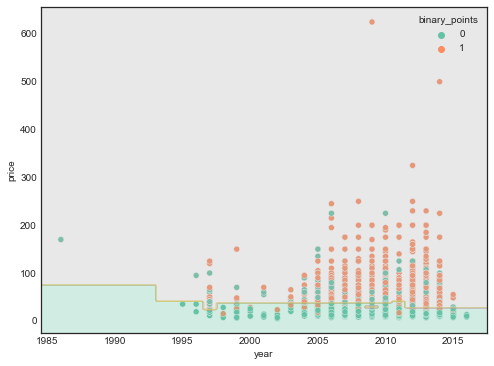

In [350]:
N = 1 # Para no graficar todos los puntos y saturar el grafico (en este caso podemos darle granularidad 1)

plt.figure(figsize = (8,6))

ax = sns.scatterplot(X_test[::N].year, X_test[::N].price, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

#### Mini-conclusión

Está bueno el análisis de esta manera. Si bien el accuracy sobre los vinos se mantiene practicamente igual que en el caso de tener en cuenta todas las características viendo este gráfico podemos sacar como conclusión que:

- Hay vinos de bajo precio en todos los años (el tiempo de estacionamiento no es determinante)
- Complementando el punto anterior vemos que los vinos más caros son los más nuevos, con lo cual podríamos hipotetizar que hay mejores técnicas de vinificación (o que los gustos de los sommeliers cambian con la época y las técnicas más viejas de vinificación no son ya de su agrado). También podríamos pensar que hay un tiempo de guarda óptimo (eso ya lo sabemos) que anda en torno a los 10/12 años, mirando el gráfico parece quedar claro. En todo caso estas son hipótesis, habrá que constatarlas.
- Los vinos de mayor puntaje suelen ser vinos caros (salvando algunas excepciones). Nada que nos sorprenda. A seguir ahorrando.

### K-Means (clustering)
No tiene mucho sentido porque ya vemos que no parece haber poblaciones demasiado separables (y menos en regiones no circulares (redondeadas) como plantea K-means, pero simplemente para que quede vemos qué pasa si intentamos correr este algoritmo sobre el set precio/año

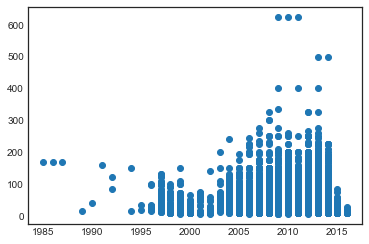

In [352]:
# Primero visualizamos la nube de datos

from sklearn.cluster import KMeans

plt.scatter(X.year,X.price, label='True Position')

In [353]:
# Planteamos una clusterización en dos grupos
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [354]:
# Mostramos dónde quedaron los centros
print(kmeans.cluster_centers_)

[[2009.84  110.52]
 [2009.56   32.32]]


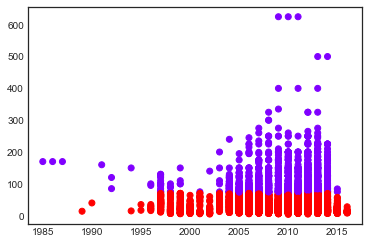

In [355]:
# Graficamos en función de la agrupación obtenida (pintando puntos de cada grupo)
plt.scatter(X.year,X.price, c = kmeans.labels_, cmap='rainbow')

[[2009.61   24.84]
 [2010.11  162.03]
 [2009.53   70.19]]


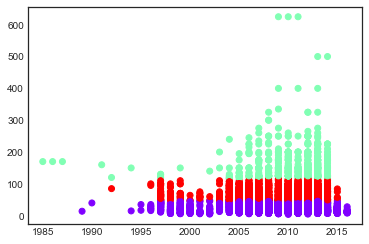

In [357]:
# Qué pasaba si planteabamos tres grupos?
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

print(kmeans.cluster_centers_)
plt.scatter(X.year,X.price, c = kmeans.labels_, cmap='rainbow')

#### Mini-(última)-conclusión
En todo caso no parece haber separado tan mal...
- En el caso de dos grupos separó en vinos caros y baratos casi de igual manera que con Adaboost (y a un costo computacional mucho menor)
- En el caso de tres grupos también parece haber separado en vinos caros, medios y baratos.